Getting familiar with DR. Mussman's research assignment

In [194]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import csv
import sklearn
import re

In [195]:
df = pd.read_csv("data/ACSST1Y2010.S0101.csv")
df["label"] = df["Label (Grouping)"].str.strip()
df.to_csv("age_estimates_only.csv", index=False)
# print(df.head)

dude = df.to_numpy()
print(dude)

[['Total population' '4,785,298' '*****' ... '1,936,867' '±2,651'
  'Total population']
 ['AGE' nan nan ... nan nan 'AGE']
 ['\xa0\xa0\xa0\xa0Under 5 years' '6.4%' '±0.1' ... '5.5%' '±0.1'
  'Under 5 years']
 ...
 ['PERCENT IMPUTED' nan nan ... nan nan 'PERCENT IMPUTED']
 ['\xa0\xa0\xa0\xa0Sex' '0.1%' '(X)' ... '(X)' '(X)' 'Sex']
 ['\xa0\xa0\xa0\xa0Age' '1.1%' '(X)' ... '(X)' '(X)' 'Age']]


In [270]:
import pandas as pd
import numpy as np
import re

def build_state_age_matrix(csv_path):
    df = pd.read_csv(csv_path)
    df["label"] = df["Label (Grouping)"].str.strip()
    # --- 1. keep the 18 "simple" age rows -----------------------------
    age_rows = df[df["Label (Grouping)"].str.match(r"^\s{4}(Under|\d)")].iloc[:18]
    age_labels = age_rows["Label (Grouping)"].str.strip().tolist()

    tot_cols = df.filter(regex=r"!!Total!!Estimate$").columns
    states = [c.split("!!")[0] for c in tot_cols]  # strip "!!Total!!Estimate"

    # --- 3. convert to floats and reshape -----------------------------
    age_pct_df = (
        age_rows[tot_cols]
        .apply(lambda s: s.str.rstrip("%").astype(float))  # strip % → float
        .T                                                 # states become rows
        .reset_index(drop=True)
    )
    age_mat = age_pct_df.to_numpy(dtype=float)  # (52, 18)
    age_mat *= .01
    
    return age_mat, states, age_labels

build_state_age_matrix("data/ACSST1Y2010.S0101.csv")

def multiply_percentages_and_totals(age_matrix, csv_path):
    df = pd.read_csv(csv_path)
    # total-population counts for each state (row 0 of each *!!Total!!Estimate column)
    totals = (
        df.filter(regex=r"!!Total!!Estimate$").iloc[0]
        .str.replace(",", "").astype(int)
        .to_numpy()                                           # shape (52,)
    )
    # broadcast: (52, 1) * (52, 18) → (52, 18)
    counts = totals[:, None] * age_matrix
    return counts.astype(int), totals
# print(state_names[:5])    # ['Alabama', 'Alaska', 'Arizona', 'Arkansas', 'California']
# print(age_groups)         # ['Under 5 years', '5 to 9 years', ... '85 years and over']

# age_matrix, state_names, age_groups = build_state_age_matrix("data/ACSST1Y2010.S0101.csv")
# multiplied, totals = multiply_percentages_and_totals(age_matrix, "data/ACSST1Y2010.S0101.csv")
# print(multiplied.shape) # 52 x 18, what I want is 9 x 52 x 18

## years 2010-2016 all have a percentage for individual totals, after that they just store the actual totals

def age_totals_no_percentage(csv_path):
    df = pd.read_csv(csv_path)
    age_rows = df[df["Label (Grouping)"].str.match(r"^\s{4}(Under|\d)")].iloc[:18]
    age_labels = age_rows["Label (Grouping)"].str.strip().tolist()
    tot_cols = df.filter(regex=r"!!Total!!Estimate$").columns
    states = [c.split("!!")[0] for c in tot_cols]  # strip "!!Total!!Estimate"
    # print(states)
    # print(len(states))
    age_matrix = df[tot_cols]
    age_matrix = age_matrix.iloc[2:20:] ##
    age_matrix = age_matrix.to_numpy() # (18 x 52). Rows are the age-group-defined totals, and columns are the states in alphabetical order
    for r in range(len(age_matrix)):
        for c in range(len(age_matrix[r])):
            age_matrix[r][c] = int(age_matrix[r][c].replace(",", ""))
    return age_matrix.T # (52x18) np array that represents the int populations for the 52 states

def populate_training_array(): # (2, 13, 1, 52)
    train_array = np.zeros((10, 52, 18))
    test_array = np.zeros((3, 52, 18)) #2021-2023
    # returned = np.array((6, ))
    i = 10
    train_index = 0
    test_index = 0
    file_path_prefix = "data/ACSST1Y20"
    while (i <= 16):
        path_string = file_path_prefix + str(i) + ".S0101.csv"
        age_matrix, state_names, age_groups = build_state_age_matrix(path_string)
        multiplied, totals = multiply_percentages_and_totals(age_matrix, path_string)
        # print(train_index)
        # print(f"year = {i} | train index = {train_index}")
        train_array[train_index] = multiplied
        np.savetxt("foo.csv", multiplied, delimiter=",")
        train_index += 1
        i += 1
    while (i <= 20):
        if (i == 20):
            i += 1
            break
        path_string = file_path_prefix + str(i) + ".S0101.csv"
        age_matrix = age_totals_no_percentage(path_string)
        # print(train_index)
        # print(f"year = {i} | train index = {train_index}")
        # print(f"train index = {train_index}")
        train_array[train_index] = age_matrix
        train_index += 1
        i += 1
    print("------------------------------------------------")
    while i <= 23:
        path_string = file_path_prefix + str(i) + ".S0101.csv"
        age_matrix = age_totals_no_percentage(path_string)
        # print(test_index)
        # print(f"year = {i} | test index = {test_index}")
        test_array[test_index] = age_matrix
        test_index += 1
        i += 1
    print(f"Training array shape = {train_array.shape}")
    print(f"Test array shape = {test_array.shape}")

    return train_array, test_array


# age_totals_no_percentage("data/ACSST1Y2017.S0101.csv")

Now that I've fucked around enough, I can make methods to repeatedly pass shit in and filter it out.

In [271]:
train_array, test_array = populate_training_array()
train_array = train_array / train_array.sum(axis=2, keepdims=True)
test_array  = test_array  / test_array.sum(axis=2, keepdims=True)
# assert np.allclose(train_array.sum(axis=2), 1, atol=1e-6)
# assert np.allclose(test_array.sum(axis=2),  1, atol=1e-6)
# train array = (10, 52, 18). meaning (years 10-19, 52 states, 18 age ranges)
# tets array = (3, 52, 18). meaning (years 21-23, 52 states, 18 age ranges)
x = train_array[:8]
y = train_array[1:9]
x =  x.reshape((8 * 52), 18)
y = y.reshape((8 * 52), 18)
print(x.shape)
print(y.shape)
test_x = test_array[:2]
test_y = test_array[1:3]
print(test_x.shape)
test_x = test_x.reshape((2*52), 18)
y_actual = test_array[1:3]
y_actual = y_actual.reshape((2 * 52), 18)

def rel_error_for_alpha(a):
    model = sklearn.linear_model.Ridge(alpha=a)
    model.fit(x, y)
    y_pred   = model.predict(test_x)          # (104, 18)
    y_actual = test_y.reshape(104, 18)        # the same shape
    rel_error = np.mean(np.abs(y_pred - y_actual) / y_actual)
    return rel_error


------------------------------------------------
Training array shape = (10, 52, 18)
Test array shape = (3, 52, 18)
(416, 18)
(416, 18)
(2, 52, 18)


Now that I am able to populate the training and testing arrays for the values, I need to test the relative error for the different values of alpha.


------------------------------------------------
Training array shape = (10, 52, 18)
Test array shape = (3, 52, 18)
After running the sweep, I know the best alpha is :1e-17 with rel_e= 0.03132402461318505


/opt/anaconda3/envs/Mussman/lib/python3.13/site-packages/sklearn/linear_model/_ridge.py:213: LinAlgWarning: Ill-conditioned matrix (rcond=3.382e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


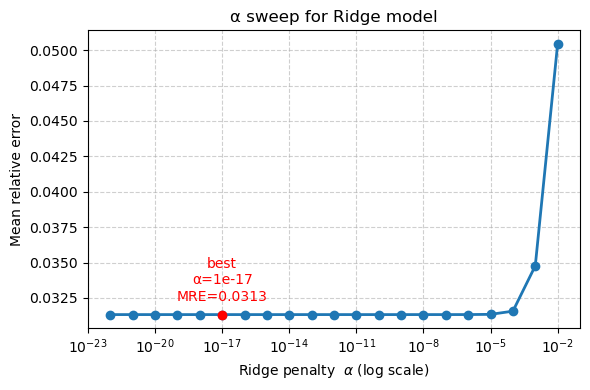

Text(0.5, 1.0, 'Ridge coefficients (α = 1e-17)')

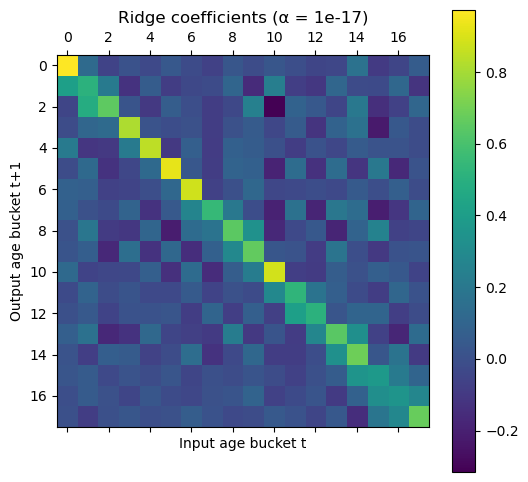

In [272]:
populate_training_array()  

alphas_rel_error = {}
min_rel_e = 1000000
a = 0.0000000000000000000001
while (a < .10000):
    relative_error = rel_error_for_alpha(a)
    alphas_rel_error[a] = relative_error
    if (relative_error < min_rel_e):
        min_rel_e = relative_error
        best_alpha = a
        
    a *= 10
print(f"After running the sweep, I know the best alpha is :{best_alpha} with rel_e= {alphas_rel_error[best_alpha]}")



# ---- nicer plot --------------------------------------------------------
alphas = np.array(sorted(alphas_rel_error))               # shape (K,)
errors = np.array([alphas_rel_error[a] for a in alphas])  # shape (K,)

fig, ax = plt.subplots(figsize=(6,4))
ax.semilogx(alphas, errors, marker='o', linewidth=2)      # log-x
ax.set_xlabel(r"Ridge penalty  $\alpha$ (log scale)")
ax.set_ylabel("Mean relative error")
ax.set_title("α sweep for Ridge model")

# highlight the minimum
idx_best = np.argmin(errors)
ax.plot(alphas[idx_best], errors[idx_best], 'ro')         # red dot
ax.annotate(f"best\nα={alphas[idx_best]:.3g}\nMRE={errors[idx_best]:.4f}",
            xy=(alphas[idx_best], errors[idx_best]),
            xytext=(0, 10), textcoords="offset points",
            ha='center', color='red')

ax.grid(True, which="both", ls='--', alpha=0.6)
plt.tight_layout()
plt.show()

import matplotlib.pyplot as plt
plt.figure(figsize=(6,6))
plt.matshow(model.coef_, fignum=0)
plt.colorbar()
plt.xlabel('Input age bucket t')
plt.ylabel('Output age bucket t+1')
plt.title('Ridge coefficients (α = %g)' % best_alpha)


# Display the plot
# plt.show()

In [76]:
# --- imports -------------------------------------------------------------
import os
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn.linear_model

# Train years: 2010–2019. Test years: 2021–2023.
TRAIN_YEARS_PERCENT = list(range(2010, 2017))  # 2010–2016: percentages
TRAIN_YEARS_COUNT = [2017, 2018, 2019] # 2017–2019: counts
TEST_YEARS_COUNT = [2021, 2022, 2023] # 2021–2023: counts

def normalize_labels(series):
    """Replace NBSP with regular space using str.translate (no regex)."""
    series = series.astype(str)
    series = series.str.replace("\u00A0", " ", regex=False)  # "\u00A0" is NBSP
    return series

def get_age_rows(df):
    labels = normalize_labels(df["Label (Grouping)"])
    stripped = labels.str.strip()
    start_idx = stripped.index[stripped.eq("Under 5 years")][0]
    end_idx = start_idx + 18
    age_rows = df.iloc[start_idx:end_idx]  # 18 rows
    return age_rows

def total_cols(df):
    total_estimate_columns = []
    for col in df.columns:
        if col.endswith("!!Total!!Estimate"):
            total_estimate_columns.append(col)
    return total_estimate_columns

def build_state_age_matrix_percent(csv_path):
    df = pd.read_csv(csv_path)
    # age_rows = get_simple_age_block(df)
    age_rows = get_age_rows(df)
    tot_cols = total_cols(df)
    age_pct_df = age_rows[tot_cols].replace('[%,]', '', regex=True).astype(float)
    age_mat = age_pct_df.T.reset_index(drop=True).to_numpy(dtype=float) * 0.01
    return age_mat

def build_state_age_matrix_counts(csv_path):
    df = pd.read_csv(csv_path)
    age_rows = get_age_rows(df)
    tot_cols = total_cols(df)
    age_cnt_df = age_rows[tot_cols].replace(',', '', regex=True).astype(int)
    age_mat = age_cnt_df.T.reset_index(drop=True).to_numpy(dtype=int)
    return age_mat

def totals_from_file(csv_path):
    df = pd.read_csv(csv_path)
    totals_cols = total_cols(df)
    totals = (df.filter(items=totals_cols).iloc[0])
    totals_no_commas = totals.replace(",", "", regex=True)
    int_casted_totals = totals_no_commas.astype(int).to_numpy()
    return int_casted_totals  # (52,)

def make_file_path(year):
    year_string = f"ACSST1Y{year}.S0101.csv"
    path = os.path.join("data", year_string)
    return path

def load_year_matrix(year):
    path = make_file_path(year)
    if year <= 2016:
        age_mat_pct = build_state_age_matrix_percent(path) # (52,18) 
        totals = totals_from_file(path).reshape(-1, 1)
        age_matrix = (totals * age_mat_pct).astype(float)
    else:
        age_matrix = build_state_age_matrix_counts(path).astype(float)  # (52,18)
    return age_matrix

def build_train_array():
    train_years = TRAIN_YEARS_PERCENT + TRAIN_YEARS_COUNT # 2010..2019
    train_mats = []
    for y in train_years:
        mat = load_year_matrix(y)
        train_mats.append(mat)
    train_array = np.stack(train_mats, axis=0) # (10, 52, 18)
    return train_array, train_years

def build_test_array():
    test_years  = TEST_YEARS_COUNT # 2021..2023
    test_mats = []
    for y in test_years:
        mat = load_year_matrix(y)
        test_mats.append(mat)
    test_array = np.stack(test_mats, axis=0) # (3, 52, 18)
    return test_array, test_years

def make_pairs(train_array, test_array):
    # normalize to proportions
    train_sum = np.clip(train_array.sum(axis=2, keepdims=True), 1e-12, a_max=None)
    test_sum = np.clip(test_array.sum(axis=2, keepdims=True),  1e-12, a_max=None)
    train_normalized = train_array / train_sum
    test_normalized = test_array / test_sum
    
    x_train = train_normalized[:9] # years 0..8
    y_train = train_normalized[1:10] # years 1..9
    x_train_reshaped = x_train.reshape(9*52, 18)
    y_train_reshaped = y_train.reshape(9*52, 18)

    x_test_reshaped = test_normalized[:2].reshape(2*52, 18)
    y_test_reshaped = test_normalized[1:3].reshape(2*52, 18)

    return x_train_reshaped, y_train_reshaped, x_test_reshaped, y_test_reshaped

def rel_error_for_alpha(alpha, x, y, test_x, test_y):
    model = sklearn.linear_model.Ridge(alpha=alpha)
    model.fit(x, y)
    pred = model.predict(tx)
    # relative error = abs(prediction-true)/true
    mre = np.mean(np.abs(pred - test_y) / np.clip(test_y, 1e-12, None))
    return mre, model

train_array, train_years = build_train_array()
test_array, test_years = build_test_array()
print("Train array shape (years, states, ages):", train_array.shape, "| Years:", train_years)
print("Test  array shape (years, states, ages):",  test_array.shape,  "| Years:", test_years)

x_train, y_train, x_test, y_test = make_pairs(train_array, test_array)
print("Train X/Y shapes:", x_train.shape, y_train.shape)
print("Test  X/Y shapes:", x_test.shape, y_test.shape)


Train array shape (years, states, ages): (10, 52, 18) | Years: [2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019]
Test  array shape (years, states, ages): (3, 52, 18) | Years: [2021, 2022, 2023]
Train X/Y shapes: (468, 18) (468, 18)
Test  X/Y shapes: (104, 18) (104, 18)



_________________________________________________________________________________________________________________________________________________________________________________________________________________
Now that the training and test arrays are built, I'll sweep the different alpha values for the ones that performs best on the L2 model.
_________________________________________________________________________________________________________________________________________________________________________________________________________________

Best alpha: 1e-06 | Best mean relative error: 0.0304648


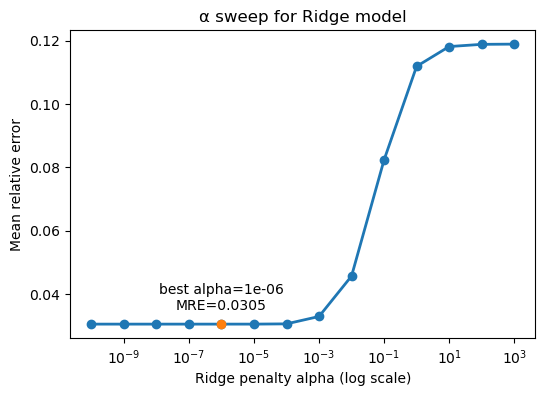

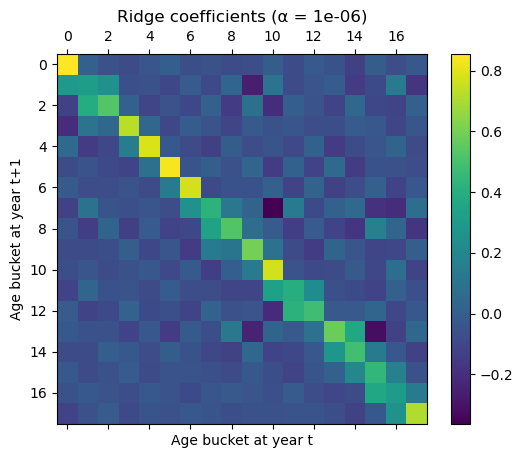

In [ ]:
alphas = [10.0**k for k in range(-10, 4)] 
scores = {}
best_alpha, best_mre, best_model = None, float('inf'), None

for a in alphas:
    mre, model = rel_error_for_alpha(a, x_train, y_train, x_test, y_test)
    scores[a] = mre
    if mre < best_mre:
        best_alpha = a
        best_mre = mre
        best_model = model

print(f"Best alpha: {best_alpha} | Best mean relative error: {best_mre:.7f}") 

alphas_sorted = np.array(sorted(scores))
errors_sorted = np.zeros_like(alphas_sorted)
for i in range(len(alphas_sorted)):
    errors_sorted[i] = scores[alphas_sorted[i]]


fig, axis = plt.subplots(figsize=(6, 4))
axis.semilogx(alphas_sorted, errors_sorted, marker='o', linewidth=2)
axis.set_xlabel(r"Ridge penalty alpha (log scale)")
axis.set_ylabel("Mean relative error")
axis.set_title("α sweep for Ridge model")
# highlight best
# ib = np.argmin(errors_sorted)
best_alpha_index = np.argmin(errors_sorted)
axis.plot(alphas_sorted[best_alpha_index], errors_sorted[best_alpha_index], 'o')
axis.annotate(f"best alpha={alphas_sorted[best_alpha_index]:.3g}\nMRE={errors_sorted[best_alpha_index]:.4f}", xy=(alphas_sorted[best_alpha_index], errors_sorted[best_alpha_index]),
            xytext=(0, 10), textcoords="offset points", ha='center')
plt.show()


plt.figure()
plt.matshow(best_model.coef_, fignum=0)
plt.colorbar()
plt.xlabel('Age bucket at year t')
plt.ylabel('Age bucket at year t+1')
plt.title(f'Ridge coefficients (α = {best_alpha:g})')
plt.show()
